# 编程作业 6 - 支持向量机

在本练习中，我们将使用支持向量机（SVM）来构建垃圾邮件分类器。 我们将从一些简单的2D数据集开始使用SVM来查看它们的工作原理。 然后，我们将对一组原始电子邮件进行一些预处理工作，并使用SVM在处理的电子邮件上构建分类器，以确定它们是否为垃圾邮件。

我们要做的第一件事是看一个简单的二维数据集，看看线性SVM如何对数据集进行不同的C值（类似于线性/逻辑回归中的正则化项）。 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat

raw_data = loadmat('data/ex6data1.mat')
raw_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Nov 13 14:28:43 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[1.9643  , 4.5957  ],
        [2.2753  , 3.8589  ],
        [2.9781  , 4.5651  ],
        [2.932   , 3.5519  ],
        [3.5772  , 2.856   ],
        [4.015   , 3.1937  ],
        [3.3814  , 3.4291  ],
        [3.9113  , 4.1761  ],
        [2.7822  , 4.0431  ],
        [2.5518  , 4.6162  ],
        [3.3698  , 3.9101  ],
        [3.1048  , 3.0709  ],
        [1.9182  , 4.0534  ],
        [2.2638  , 4.3706  ],
        [2.6555  , 3.5008  ],
        [3.1855  , 4.2888  ],
        [3.6579  , 3.8692  ],
        [3.9113  , 3.4291  ],
        [3.6002  , 3.1221  ],
        [3.0357  , 3.3165  ],
        [1.5841  , 3.3575  ],
        [2.0103  , 3.2039  ],
        [1.9527  , 2.7843  ],
        [2.2753  , 2.7127  ],
        [2.3099  , 2.9584  ],
        [2.8283  , 2.6309  ],
        [3.0473  , 2.2931  ],
        [2.4827  , 2.0373  ],
        [2.5057 

我们将其用散点图表示，其中类标签由符号表示（+表示正类，o表示负类）。

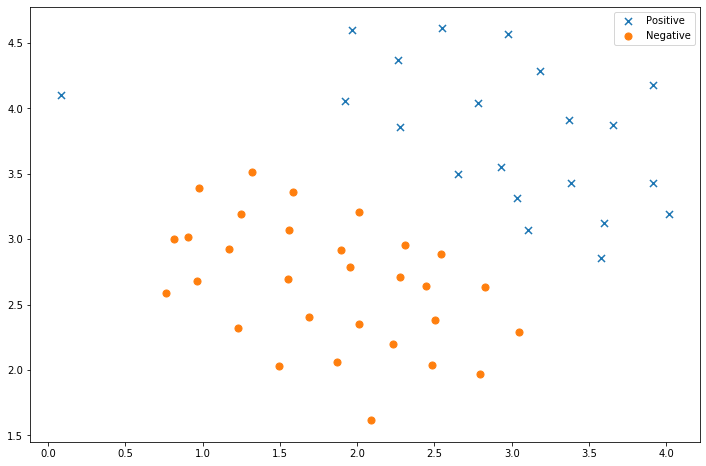

In [6]:
data = pd.DataFrame(raw_data['X'], columns=['X1', 'X2'])
data['y'] = raw_data['y']

positive = data[data['y'].isin([1])]
negative = data[data['y'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['X1'], positive['X2'], s=50, marker='x', label='Positive')
ax.scatter(negative['X1'], negative['X2'], s=50, marker='o', label='Negative')
ax.legend()
plt.show()

请注意，还有一个异常的正例在其他样本之外。
这些类仍然是线性分离的，但它非常紧凑。 我们要训练线性支持向量机来学习类边界。 在这个练习中，我们没有从头开始执行SVM的任务，所以我要用scikit-learn。

In [7]:
from sklearn import svm
svc = svm.LinearSVC(C=1, loss='hinge', max_iter=1000)
svc

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)

首先，我们使用 C=1 看下结果如何。

In [8]:
svc.fit(data[['X1', 'X2']], data['y'])
svc.score(data[['X1', 'X2']], data['y'])

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9803921568627451

其次，让我们看看如果C的值越大，会发生什么

In [9]:
svc2 = svm.LinearSVC(C=100, loss='hinge', max_iter=1000)
svc2.fit(data[['X1', 'X2']], data['y'])
svc2.score(data[['X1', 'X2']], data['y'])

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9411764705882353

这次我们得到了训练数据的完美分类，但是通过增加C的值，我们创建了一个不再适合数据的决策边界。 我们可以通过查看每个类别预测的置信水平来看出这一点，这是该点与超平面距离的函数。

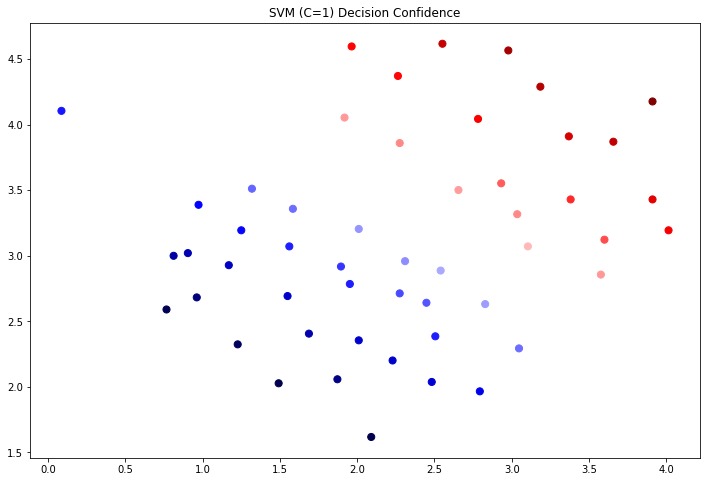

In [10]:
data['SVM 1 Confidence'] = svc.decision_function(data[['X1', 'X2']])

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(data['X1'], data['X2'], s=50, c=data['SVM 1 Confidence'], cmap='seismic')
ax.set_title('SVM (C=1) Decision Confidence')
plt.show()

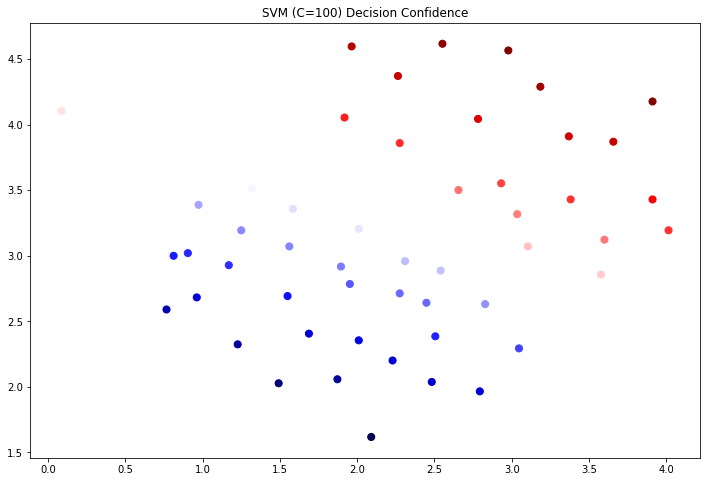

In [11]:
data['SVM 2 Confidence'] = svc2.decision_function(data[['X1', 'X2']])

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(data['X1'], data['X2'], s=50, c=data['SVM 2 Confidence'], cmap='seismic')
ax.set_title('SVM (C=100) Decision Confidence')
plt.show()

可以看看靠近边界的点的颜色，区别是有点微妙。 如果您在练习文本中，则会出现绘图，其中决策边界在图上显示为一条线，有助于使差异更清晰。

现在我们将从线性SVM转移到能够使用内核进行非线性分类的SVM。 我们首先负责实现一个高斯核函数。 虽然scikit-learn具有内置的高斯内核，但为了实现更清楚，我们将从头开始实现。

In [12]:
def gaussian_kernel(x1, x2, sigma):
# INPUT：两个维度的值x1,x2,高斯核参数sigma
# OUTPUT：高斯核函数计算后的值
# TODO：根据参数和输入的数据计算高斯核函数
    
    # STEP：计算高斯核函数，这里的输入时向量化的
    # your code here  (appro ~ 1 lines)
     return np.exp(-(np.sum((x1 - x2) ** 2) / (2 * (sigma ** 2))))

In [13]:
x1 = np.array([1.0, 2.0, 1.0])
x2 = np.array([0.0, 4.0, -1.0])
sigma = 2

gaussian_kernel(x1, x2, sigma)

0.32465246735834974

如果你的程序正确，这里的输出应该是0.32465246735834974

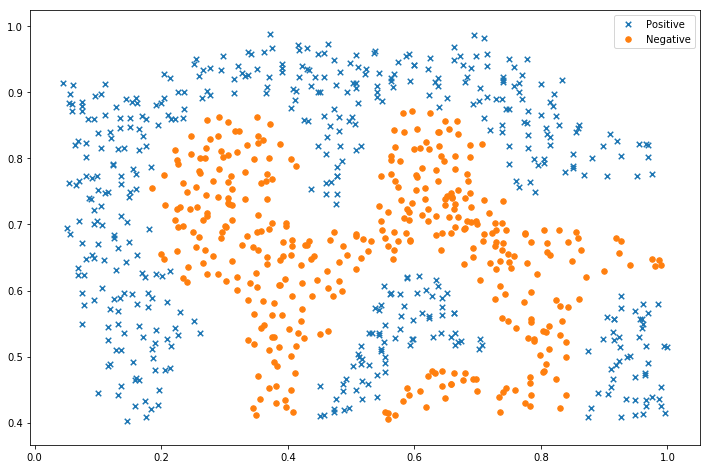

In [12]:
raw_data = loadmat('ex6data2.mat')

data = pd.DataFrame(raw_data['X'], columns=['X1', 'X2'])
data['y'] = raw_data['y']

positive = data[data['y'].isin([1])]
negative = data[data['y'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['X1'], positive['X2'], s=30, marker='x', label='Positive')
ax.scatter(negative['X1'], negative['X2'], s=30, marker='o', label='Negative')
ax.legend()
plt.show()

对于该数据集，我们将使用内置的RBF内核构建支持向量机分类器，并检查其对训练数据的准确性。 为了可视化决策边界，这一次我们将根据实例具有负类标签的预测概率来对点做阴影。 从结果可以看出，它们大部分是正确的。

In [13]:
svc = svm.SVC(C=100, gamma=10, probability=True)
svc

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [14]:
svc.fit(data[['X1', 'X2']], data['y'])
svc.score(data[['X1', 'X2']], data['y'])

0.9698725376593279

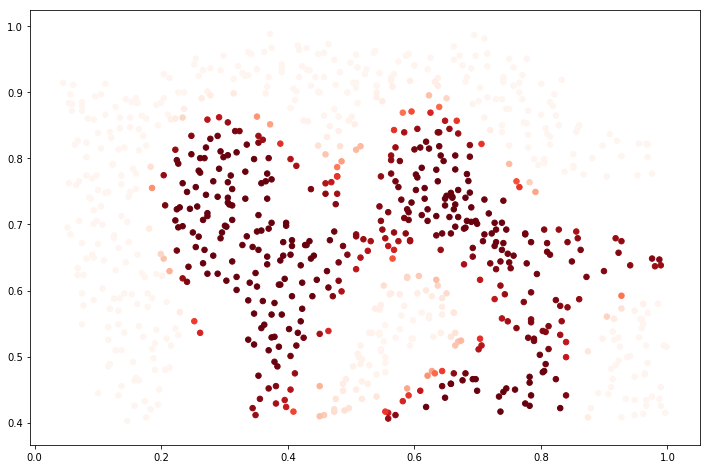

In [15]:
data['Probability'] = svc.predict_proba(data[['X1', 'X2']])[:,0]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(data['X1'], data['X2'], s=30, c=data['Probability'], cmap='Reds')
plt.show()

对于第三个数据集，我们给出了训练和验证集，并且基于验证集性能为SVM模型找到最优超参数。 虽然我们可以使用scikit-learn的内置网格搜索来做到这一点，但是本着遵循练习的目的，我们将从头开始实现一个简单的网格搜索。

In [16]:
raw_data = loadmat('ex6data3.mat')

X = raw_data['X']
Xval = raw_data['Xval']
y = raw_data['y'].ravel()
yval = raw_data['yval'].ravel()

#设置可选的超参数
C_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
gamma_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
#初始化变量
best_score = 0
best_params = {'C': None, 'gamma': None}

# TODO：寻找SVM模型最优的超参数
# STEP1：遍历每一个超参数
for C in C_values:
    for gamma in gamma_values:
    # STEP2：调用SVM包，计算当前参数下的得分
    # your code here  (appro ~ 2 lines) 
        svc = svm.SVC(C=C, gamma=gamma)
        svc.fit(X, y)
        score =  svc.score(Xval, yval)
        # STEP3：替换得分最高的超参数组合
        # your code here  (appro ~ 3 lines) 
        if score > best_score:
            best_score = score
            best_params['C'] =  C
            best_params['gamma'] = gamma

best_score, best_params

(0.96499999999999997, {'C': 0.3, 'gamma': 100})

如果代码正确，这里的输出应该是：(0.96499999999999997, {'C': 0.3, 'gamma': 100})

现在，我们将进行第二部分的练习。 在这一部分中，我们的目标是使用SVM来构建垃圾邮件过滤器。 在练习文本中，有一个任务涉及一些文本预处理，以获得适合SVM处理的格式的数据。 然而，这个任务很简单（将字词映射到为练习提供的字典中的ID），而其余的预处理步骤（如HTML删除，词干，标准化等）已经完成。 我将跳过机器学习任务，而不是重现这些预处理步骤，其中包括从预处理过的训练集构建分类器，以及将垃圾邮件和非垃圾邮件转换为单词出现次数的向量的测试数据集。

In [18]:
spam_train = loadmat('spamTrain.mat')
spam_test = loadmat('spamTest.mat')

spam_train

{'X': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Nov 13 14:27:25 2011',
 '__version__': '1.0',
 'y': array([[1],
        [1],
        [0],
        ..., 
        [1],
        [0],
        [0]], dtype=uint8)}

In [19]:
# TODO： 获取训练和测试数据，这里应注意把标签y矩阵拉直
X = spam_train['X']
Xtest = spam_test['Xtest']
y = spam_train['y'].ravel()
ytest = spam_test['ytest'].ravel()

X.shape, y.shape, Xtest.shape, ytest.shape

((4000, 1899), (4000,), (1000, 1899), (1000,))

如果你的代码正确，这里输出的应该是((4000, 1899), (4000,), (1000, 1899), (1000,))

每个文档已经转换为一个向量，其中1,899个维对应于词汇表中的1,899个单词。 它们的值为二进制，表示文档中是否存在单词。 在这一点上，训练评估是用一个分类器拟合测试数据的问题。

In [20]:
svc = svm.SVC()
svc.fit(X, y)
print('Training accuracy = {0}%'.format(np.round(svc.score(X, y) * 100, 2)))

Training accuracy = 94.4%


In [21]:
print('Test accuracy = {0}%'.format(np.round(svc.score(Xtest, ytest) * 100, 2)))

Test accuracy = 95.3%


这个结果是使用默认参数的。 我们可能会使用一些参数调整来获得更高的精度，尽管95％的精度相当不错。

在下一个作业中，我们将使用K-Means和主成分分析进行聚类和图像压缩。